<a href="https://colab.research.google.com/github/ncsu-landscape-dynamics/LAMP_assay_automation/blob/main/Working_pytorch_instance_imseg_ccrop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

class four_chs(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None, target_transform=None):
        self.root = root
        self.transforms = transforms
        self.target_transform = target_transform
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "imgs_centercropped"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "masks_centercropped"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "imgs_centercropped", self.imgs[idx])
        mask_path = os.path.join(self.root, "masks_centercropped", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        # Convert from image object to array
        mask = np.array(mask)
        
        obj_ids = np.unique(mask)
        # first is background, other values are noise, removed them
        obj_ids = obj_ids[-4:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

Mounted at /content/drive


In [2]:
#os.chdir('drive/MyDrive/Colab Notebooks')

%%shell

# Download TorchVision repo to use some files from
# references/detection
#git clone https://github.com/pytorch/vision.git
git clone https://github.com/John-Polo/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 29544, done.
remote: Counting objects: 100% (2087/2087), done.
remote: Compressing objects: 100% (573/573), done.
remote: Total 29544 (delta 1562), reused 1967 (delta 1475), pack-reused 27457
Receiving objects: 100% (29544/29544), 37.94 MiB | 35.07 MiB/s, done.
Resolving deltas: 100% (22172/22172), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


In [3]:
# testing
#dataset0 = four_chs(root="/content/drive/MyDrive/APHIS Farm Bill (2020Milestones)/Protocols/For John/images/New set for John/collection/four_chambers")

In [4]:
# testing
#dataset0[0]

In [3]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
 
# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
 
# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [5]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [7]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = four_chs(root = '/content/drive/MyDrive/APHIS Farm Bill (2020Milestones)/Protocols/For John/images/New set for John/collection/four_chambers', transforms = get_transform(train=True))    
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=1, shuffle=True, num_workers=2,
 collate_fn=utils.collate_fn)
## For Training
#images,targets = next(iter(data_loader))
#images = list(image for image in images)
#targets = [{k: v for k, v in t.items()} for t in targets]
#output = model(images,targets)   # Returns losses and detections
## For inference
#model.eval()
#x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
#predictions = model(x)          

In [8]:
# use our dataset and defined transformations
dataset = four_chs(root = '/content/drive/MyDrive/APHIS Farm Bill (2020Milestones)/Protocols/For John/images/New set for John/collection/four_chambers', transforms = get_transform(train=True))
dataset_test = four_chs(root = '/content/drive/MyDrive/APHIS Farm Bill (2020Milestones)/Protocols/For John/images/New set for John/collection/four_chambers', transforms = get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-4])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-4:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has five classes
num_classes = 2

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [ ]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

In [ ]:
# https://pytorch.org/tutorials/beginner/saving_loading_models.html
# Save the model and its settings:

# state_dict holds the model parameters. Not sure if necessary due to next command,
# but this won't hurt.  
torch.save(model.state_dict(), "/content/drive/MyDrive/APHIS Farm Bill (2020Milestones)/Protocols/For John/images/New set for John/collection/four_chambers/model/MaskModelParams.pth")

# Save "the whole model"
# "This save/load process uses the most intuitive syntax and involves the least 
# amount of code. Saving a model in this way will save the entire module using 
# Python’s pickle module. The disadvantage of this approach is that the 
# serialized data is bound to the specific classes and the exact directory 
# structure used when the model is saved. The reason for this is because pickle 
# does not save the model class itself. Rather, it saves a path to the file 
# containing the class, which is used during load time. Because of this, your 
# code can break in various ways when used in other projects or after refactors."
# Call "model.eval()" before saving. 
torch.save(model, "/content/drive/MyDrive/APHIS Farm Bill (2020Milestones)/Protocols/For John/images/New set for John/collection/four_chambers/model/MaskInstanceModel.pth")

# Not sure what is supposed to go in the {}...
#torch.save({
#            'epoch': epoch,
#            'model_state_dict': model.state_dict(),
#            'optimizer_state_dict': optimizer.state_dict(),
#            'loss': loss,
#            ...
#            }, PATH)

In [ ]:
dataset_test[3]

In [14]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [14]:
# This tests the model with completely new images I created by manually
# manipulating the images in the original set.

from torchvision.io import read_image
from torchvision.transforms.functional import convert_image_dtype

dog1_int = read_image('/content/drive/MyDrive/APHIS Farm Bill (2020Milestones)/Protocols/For John/images/New set for John/collection/four_chambers/newtestimgs/set100m_vh_4.png')
dog2_int = read_image('/content/drive/MyDrive/APHIS Farm Bill (2020Milestones)/Protocols/For John/images/New set for John/collection/four_chambers/newtestimgs/set100m_vh_5.png')


# The data need to be converted to GPU, or cuda, compatible. 
# An example of loading model and data:
#device = torch.device("cuda")
#model = TheModelClass(*args, **kwargs)
#model.load_state_dict(torch.load(PATH))
#model.to(device)
# Make sure to call input = input.to(device) on any input tensors that you feed to the model

dog1 = dog1_int.to(device)
dog2 = dog2_int.to(device)

batch_int = torch.stack([dog1, dog2])
batch = convert_image_dtype(batch_int, dtype=torch.float)

new_dat = model(batch)


In [ ]:
new_dat[0]

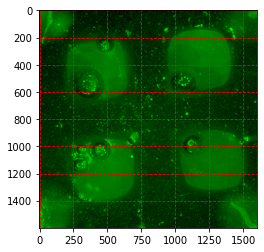

In [25]:
img1 = Image.fromarray(dog1_int.permute(1, 2, 0).byte().numpy())

plt.imshow(img1)
ax = plt.gca()
ax.grid(True, color='r', linestyle='--')
plt.draw()
plt.show()

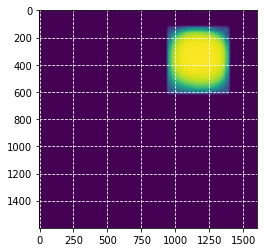

In [26]:
pred1 = Image.fromarray(new_dat[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

plt.imshow(pred1)
ax = plt.gca()
ax.grid(True, color='w', linestyle='--')
plt.draw()
plt.show()

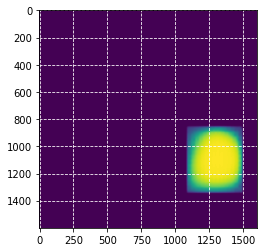

In [28]:
pred1 = Image.fromarray(new_dat[0]['masks'][1, 0].mul(255).byte().cpu().numpy())

plt.imshow(pred1)
ax = plt.gca()
ax.grid(True, color='w', linestyle='--')
plt.draw()
plt.show()

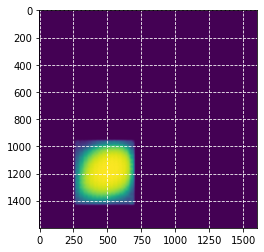

In [29]:
pred1 = Image.fromarray(new_dat[0]['masks'][2, 0].mul(255).byte().cpu().numpy())

plt.imshow(pred1)
ax = plt.gca()
ax.grid(True, color='w', linestyle='--')
plt.draw()
plt.show()

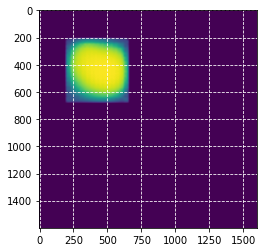

In [30]:
pred1 = Image.fromarray(new_dat[0]['masks'][3, 0].mul(255).byte().cpu().numpy())

plt.imshow(pred1)
ax = plt.gca()
ax.grid(True, color='w', linestyle='--')
plt.draw()
plt.show()

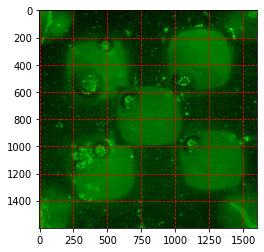

In [31]:
img3 = Image.fromarray(dog2_int.permute(1, 2, 0).byte().numpy())

plt.imshow(img3)
ax = plt.gca()
ax.grid(True, color='r', linestyle='--')
plt.draw()
plt.show()

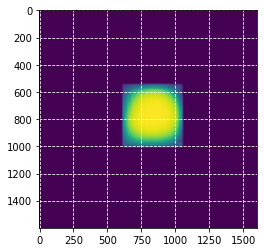

In [37]:
pred1 = Image.fromarray(new_dat[1]['masks'][0, 0].mul(255).byte().cpu().numpy())

plt.imshow(pred1)
ax = plt.gca()
ax.grid(True, color='w', linestyle='--')
plt.draw()
plt.show()

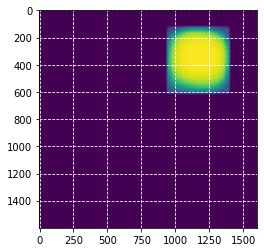

In [36]:
pred1 = Image.fromarray(new_dat[1]['masks'][1, 0].mul(255).byte().cpu().numpy())

plt.imshow(pred1)
ax = plt.gca()
ax.grid(True, color='w', linestyle='--')
plt.draw()
plt.show()

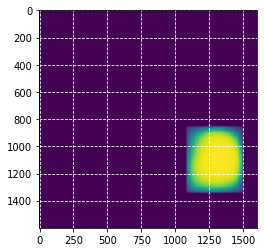

In [33]:
pred1 = Image.fromarray(new_dat[1]['masks'][2, 0].mul(255).byte().cpu().numpy())

plt.imshow(pred1)
ax = plt.gca()
ax.grid(True, color='w', linestyle='--')
plt.draw()
plt.show()

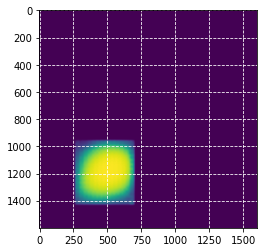

In [34]:
pred1 = Image.fromarray(new_dat[1]['masks'][3, 0].mul(255).byte().cpu().numpy())

plt.imshow(pred1)
ax = plt.gca()
ax.grid(True, color='w', linestyle='--')
plt.draw()
plt.show()

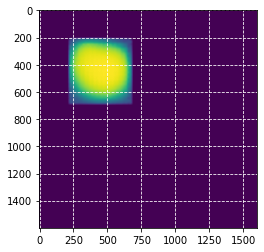

In [35]:
pred1 = Image.fromarray(new_dat[1]['masks'][4, 0].mul(255).byte().cpu().numpy())

plt.imshow(pred1)
ax = plt.gca()
ax.grid(True, color='w', linestyle='--')
plt.draw()
plt.show()